In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import math

In [ ]:
# Data Preprocessing
df_og = pd.read_csv("/content/one_hot.csv")

In [ ]:
# Handling missing CGPA values using KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_og['CGPA'] = imputer.fit_transform(df_og[['CGPA']])

In [ ]:
# Drop unnecessary columns
df_og = df_og.drop(['College', 'HSC', 'SSC', 'Additional Info'], axis=1)

# One-hot encode Degree and Course columns
columns_to_encode = ['Degree', 'Course']
df_og = pd.get_dummies(df_og, columns=columns_to_encode, drop_first=False)

In [ ]:
# Duplicate data to increase sample size
df_copy = df_og.copy()
df_og = pd.concat([df_og, df_copy], ignore_index=True)

In [ ]:
# Prepare datasets for Role and Company prediction
df_role = df_og.dropna(subset=['Role'])
df_company = df_og.dropna(subset=['Company'])

X_role = df_role.drop(['Role', 'Company', 'Name'], axis=1)
Y_role = df_role['Role']
X_company = df_company.drop(['Role', 'Company', 'Name'], axis=1)
Y_company = df_company['Company']

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{title} - Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

In [ ]:
# Function to plot feature importance
def plot_feature_importance_all(model, feature_names, title):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importance)), importance[sorted_idx], align='center')
    plt.yticks(range(len(importance)), np.array(feature_names)[sorted_idx])
    plt.title(f'{title} - Feature Importance')
    plt.xlabel('Feature Importance Score')
    plt.show()

# Example usage:
#plot_feature_importance_all(role_model_rf, X_role.columns, "Role Model")
#plot_feature_importance_all(company_model_rf, X_company.columns, "Company Model")

In [ ]:
# Function to plot feature importance with a limit on the number of features displayed
def plot_feature_importance(model, feature_names, title, top_n=10):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]

    # Select the top N features
    top_idx = sorted_idx[:top_n]

    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importance[top_idx], align='center')
    plt.yticks(range(top_n), np.array(feature_names)[top_idx])
    plt.title(f'{title} - Top {top_n} Feature Importance')
    plt.xlabel('Feature Importance Score')
    plt.show()

# Example usage:
# plot_feature_importance(role_model_xgb, X_role.columns, "Role Model", top_n=15)
# plot_feature_importance(company_model_xgb, X_company.columns, "Company Model", top_n=15)


In [ ]:
# One-hot encode Y_role and Y_company
ohe_role = OneHotEncoder(sparse_output=False)
Y_role_encoded = ohe_role.fit_transform(df_role[['Role']])
ohe_company = OneHotEncoder(sparse_output=False)
Y_company_encoded = ohe_company.fit_transform(df_company[['Company']])

In [ ]:
# Train-test split
X_role_train, X_role_test, Y_role_train, Y_role_test = train_test_split(X_role, Y_role, test_size=0.2, random_state=42)
X_company_train, X_company_test, Y_company_train, Y_company_test = train_test_split(X_company, Y_company, test_size=0.2, random_state=42)

In [ ]:
# Standardization of features
scaler = StandardScaler()
X_role_train_scaled = scaler.fit_transform(X_role_train)
X_role_test_scaled = scaler.transform(X_role_test)

X_company_train_scaled = scaler.fit_transform(X_company_train)
X_company_test_scaled = scaler.transform(X_company_test)

In [ ]:
# Role Prediction Model
role_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
role_model_rf.fit(X_role_train_scaled, Y_role_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Company Prediction Model
company_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
company_model_rf.fit(X_company_train_scaled, Y_company_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Function to get top N predictions with probabilities
def get_top_n_predictions(model, X_data, encoder, top_n=5):
    predictions_prob = model.predict_proba(X_data)
    top_n_preds = []
    for i in range(len(predictions_prob)):
        prob = predictions_prob[i]
        top_indices = np.argsort(prob)[-top_n:][::-1]
        top_probs = prob[top_indices]
        top_classes = np.array(encoder.categories_[0])[top_indices]
        top_n_preds.append(list(zip(top_classes, top_probs)))
    return top_n_preds

In [ ]:
# Function to predict top roles and companies
def predict_for_name(df, name, role_model, company_model, ohe_role, ohe_company, top_n=5):
    data = df[df['Name'] == name]
    if data.empty:
        raise ValueError(f"No data found for the name: {name}")

    # Preprocess input
    X_data = data.drop(['Name', 'Role', 'Company'], axis=1)
    X_data_scaled = scaler.transform(X_data)

    # Get top predictions for Role and Company
    top_roles = get_top_n_predictions(role_model, X_data_scaled, ohe_role, top_n)
    top_companies = get_top_n_predictions(company_model, X_data_scaled, ohe_company, top_n)

    return top_roles, top_companies

In [ ]:
# Model Evaluation
Y_role_pred = role_model_rf.predict(X_role_test_scaled)
Y_company_pred = company_model_rf.predict(X_company_test_scaled)

In [ ]:
# Accuracy Scores
role_accuracy = accuracy_score(Y_role_test, Y_role_pred)
company_accuracy = accuracy_score(Y_company_test, Y_company_pred)

print(f"Role Prediction Accuracy: {role_accuracy}")
print(f"Company Prediction Accuracy: {company_accuracy}")

Role Prediction Accuracy: 0.7209302325581395
Company Prediction Accuracy: 0.813953488372093


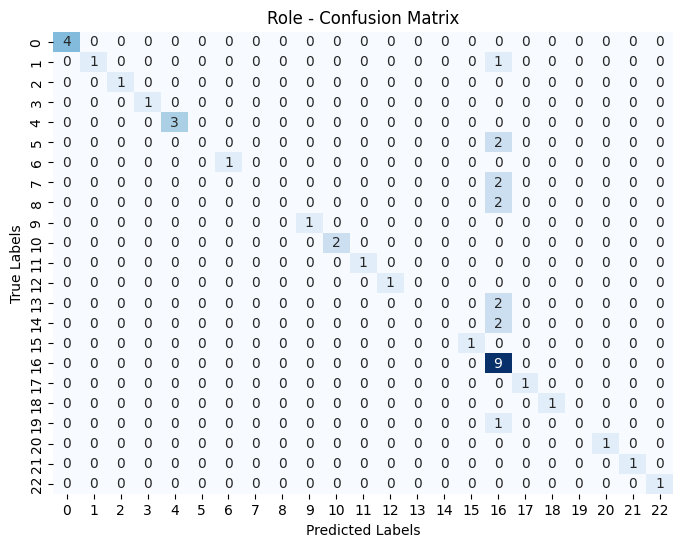

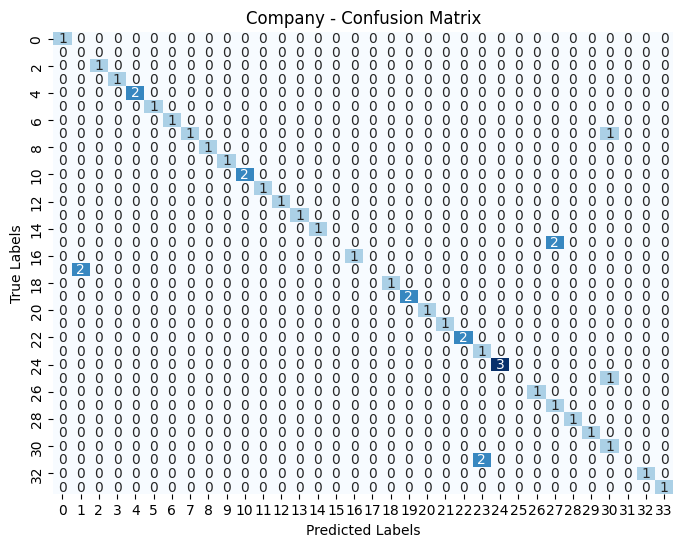

In [ ]:
# Confusion Matrix Visualization
plot_confusion_matrix(Y_role_test, Y_role_pred, "Role")
plot_confusion_matrix(Y_company_test, Y_company_pred, "Company")

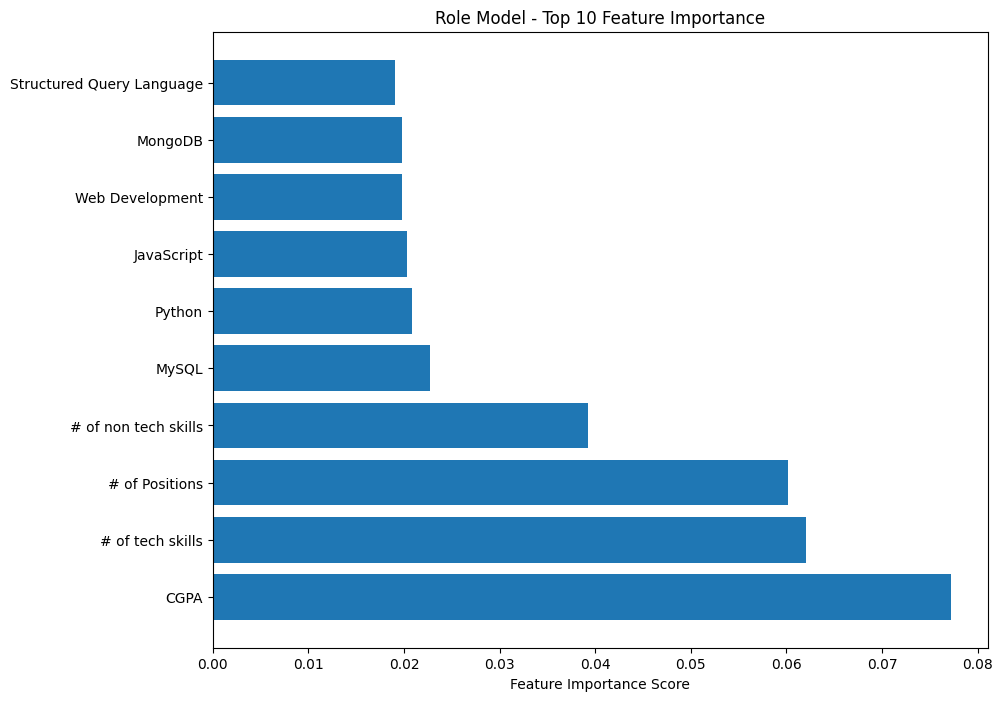

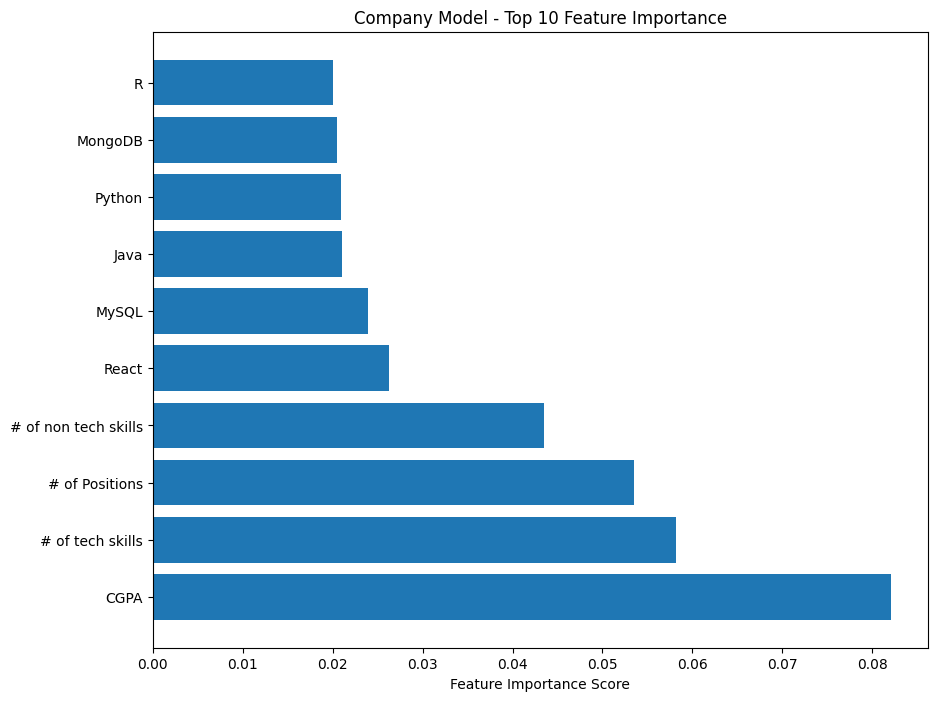

In [ ]:
# Feature Importance Visualization
plot_feature_importance(role_model_rf, X_role.columns, "Role Model")
plot_feature_importance(company_model_rf, X_company.columns, "Company Model")

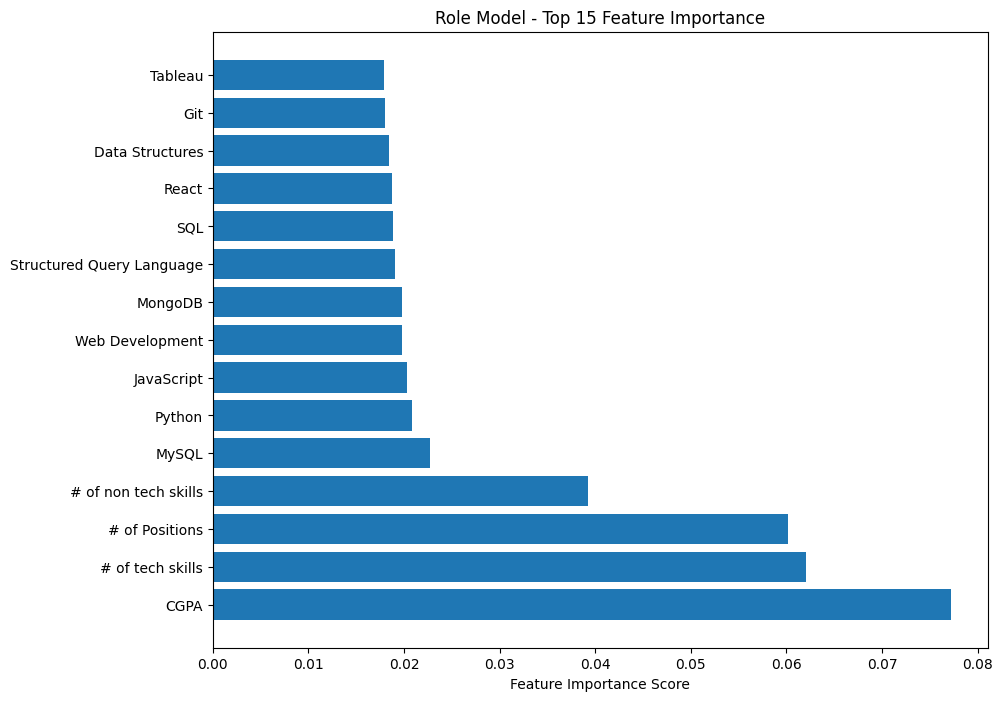

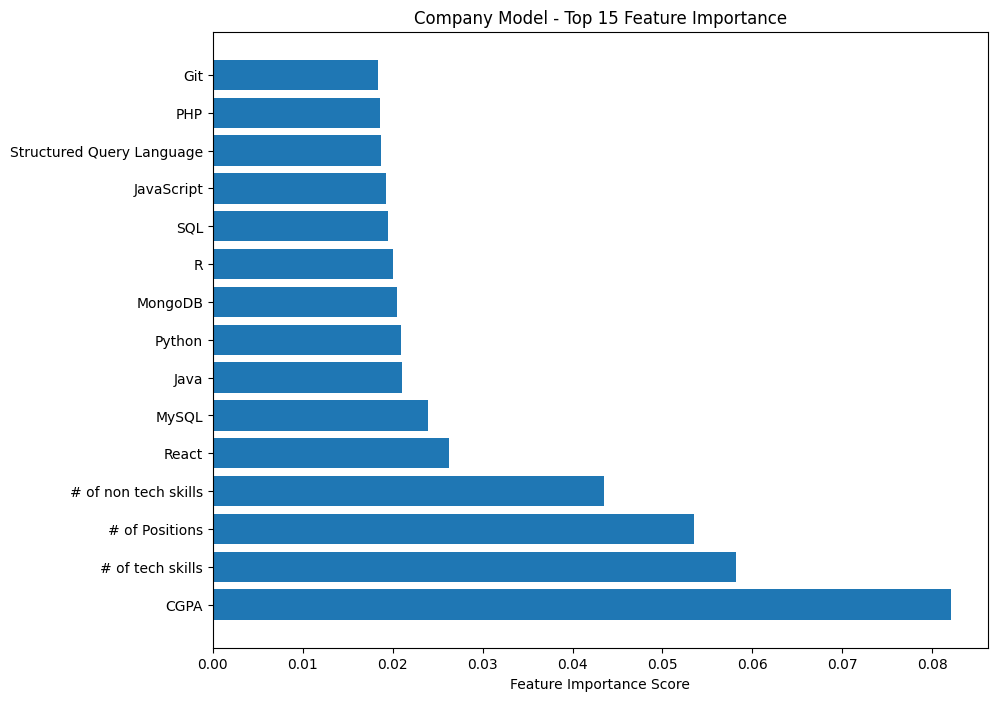

In [ ]:
plot_feature_importance(role_model_rf, X_role.columns, "Role Model", top_n=15)
plot_feature_importance(company_model_rf, X_company.columns, "Company Model", top_n=15)

In [ ]:
# Example usage for a name
name = "Basuri Bhujade"
top_roles, top_companies = predict_for_name(df_og, name, role_model_rf, company_model_rf, ohe_role, ohe_company)

print(f"Top 5 Roles for {name}:")
for role, prob in top_roles[0]:
    print(f"Role: {role}, Probability: {prob:.4f}")
print()
print(f"Top 5 Companies for {name}:")
for company, prob in top_companies[0]:
    print(f"Company: {company}, Probability: {prob:.4f}")

Top 5 Roles for Basuri Bhujade:
Role: Assistant Product Manager, Probability: 0.6400
Role: Analyst, Probability: 0.0700
Role: Associate SDE , Probability: 0.0500
Role: Data Engineer, Probability: 0.0500
Role: Machine Learning Engineer, Probability: 0.0300

Top 5 Companies for Basuri Bhujade:
Company: Transunioun, Probability: 0.6800
Company: JPMC, Probability: 0.0800
Company: PhonePe, Probability: 0.0400
Company: Resosoft Services LLP, Probability: 0.0300
Company: Cash Rich, Probability: 0.0200


In [ ]:
# Example usage for a name
name = "Anmol Khy"
top_roles, top_companies = predict_for_name(df_og, name, role_model_rf, company_model_rf, ohe_role, ohe_company)

print(f"Top 5 Roles for {name}:")
for role, prob in top_roles[0]:
    print(f"Role: {role}, Probability: {prob:.4f}")
print()
print(f"Top 5 Companies for {name}:")
for company, prob in top_companies[0]:
    print(f"Company: {company}, Probability: {prob:.4f}")

Top 5 Roles for Anmol Khy:
Role: Data Engineer, Probability: 0.8500
Role: SDE, Probability: 0.0400
Role: ITD, Probability: 0.0300
Role: Analyst, Probability: 0.0200
Role: Associate SDE , Probability: 0.0100

Top 5 Companies for Anmol Khy:
Company: Cash Rich, Probability: 0.8900
Company: Transunion, Probability: 0.0200
Company: Barclays, Probability: 0.0200
Company: ISS , Probability: 0.0100
Company: KCDH, Probability: 0.0100


In [ ]:
# Save the models and encoders for future use
joblib.dump(role_model_rf, 'role_rf_model.pkl')
joblib.dump(company_model_rf, 'company_rf_model.pkl')
joblib.dump(ohe_role, 'ohe_role.pkl')
joblib.dump(ohe_company, 'ohe_company.pkl')


['ohe_company.pkl']